# Otimizando Consultas

📌 **Contexto**

Vocês foram contratados pela Amazon, e durante a entrevista de emprego, um problema importante foi levantado:

🔍 **Descrição do Problema**
A busca por produtos precisa ser rápida e eficiente, pois os usuários realizam consultas com alta frequência. Para garantir um desempenho satisfatório, essa busca deve rodar em múltiplos servidores.

⚙️ **Infraestrutura disponível**:
- Máquinas disponíveis: 200 servidores com 1GB de RAM e 10GB de armazenamento.
- Número de produtos: 350 bilhões de itens cadastrados.

📏 Se cada item ocupa 16 bytes de memória teriamos precisariamos de 5TB

🎯 Tarefa a ser resolvida
    O objetivo é desenvolver uma solução eficiente que permita verificar rapidamente se um item provavelmente está presente em um conjunto muito grande de dados, sem precisar armazenar todos os itens na memória.


# Filtro de Bloom

In [ ]:
import hashlib
import math
import numpy as np

### Estrutura do Filtro


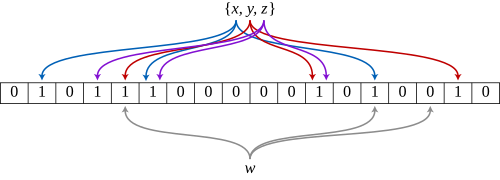

1. Array de bits

```python
    np.zeros(size, dtype=bool)
```

2. Metodos
    - Adicionar 
    - Buscar  (in)

3. funçoes hash

In [ ]:
class BloomFilter:
    def __init__(self, size, hash_count, strategy):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = np.zeros(size, dtype=bool)
        self.strategy = strategy

    def add(self, item):
        for index in self.strategy(item, self.size, self.hash_count):
            self.bit_array[index] = True

    def __contains__(self, item):
        return all(self.bit_array[i] for i in self.strategy(item, self.size, self.hash_count))

### Funções Hash

Vamos utilizar funcoes bem conhecidas `md5` e `sha1`

**Parâmetros `m` e `k` nas funções de hash do Filtro de Bloom**

- **`m`**: Representa o tamanho do array de bits do filtro de Bloom. É a quantidade total de posições disponíveis para marcar a presença dos elementos. Um valor maior de `m` reduz a taxa de falsos positivos, mas consome mais memória.

- **`k`**: Indica o número de funções hash utilizadas. Cada elemento inserido gera `k` posições diferentes no array de bits. Um valor adequado de `k` equilibra a chance de colisões e a eficiência do filtro.

Esses parâmetros são essenciais para controlar a precisão e o uso de memória do filtro de Bloom.

In [ ]:
def hash_md5_sha1(item, m, k):
    hashes = []
    for i in range(k):
        h1 = int(hashlib.md5((item + str(i)).encode()).hexdigest(), 16)
        h2 = int(hashlib.sha1((item + str(i)).encode()).hexdigest(), 16)
        combined = (h1 + i * h2) % m
        hashes.append(combined)
    return hashes

📌 **Atenção** :


```python
combined = (h1 + i * h2) % m
```
- h1 e h2 são _numéros_ de 128bits
    - por isso a conversão `int(hashlib.md5((item + str(i)).encode()).hexdigest(), 16)`
- Um número de 128bits certamente e bem maior que $m$
    - por isso utilizamo o modulo `% m`, para que o resto da divisão seja utilizdo para mapear a função a posicao do array



### Testando o Filtro de Bloom,

Definimos os parametros
- filtro de 20 bits
- 4 funcoes hash

In [ ]:
m=20
k=4

Criando o filtro

In [ ]:
filtro = BloomFilter(m, k, strategy=hash_md5_sha1)

In [ ]:
filtro.bit_array

**Inserindo e consultando elementos**

In [ ]:
words = ["gato", "cachorro", "rato" , "capivara"]
for word in words:
    filtro.add(word)

In [ ]:
print("gato" in filtro)  
print("cachorro" in filtro)  
print("leão" in filtro)         # Provavelmente False
print("rato" in filtro)

In [ ]:
filtro.bit_array

## Colisões e Falsos Positivos

Como não armazenamos os dados, o filtro pode indicar que um item está presente quando não foi inserido (falso positivo).

In [ ]:
words = ["coruja", "macaco" , "morcego" , "cavalo" , "cobra"]
for word in words:
    filtro.add(word)

In [ ]:
test_word = "tatu"
if test_word in filtro:
    print(f"'{test_word}' pode estar presente (falso positivo?)")
else:
    print(f"'{test_word}' certamente não está presente")

In [ ]:
test_word = "elefante"
if test_word in filtro:
    print(f"'{test_word}' pode estar presente (falso positivo?)")
else:
    print(f"'{test_word}' certamente não está presente")

In [ ]:
print(filtro.bit_array)

In [ ]:
hash_md5_sha1("elefante",m,k)

## Diferentes Estratégia de hashing

### Estratégia 2: Funções Hash Leves (não criptograficas)

Duas funções hash não-criptográficas populares são `djb2` e `sdbm`. Elas são geralmente produzem uma boa distribuição, o que é importante para minimizar colisões e falsos positivos.

Para gerar $k$ hashes a partir de apenas duas funções $hash$, usamos a técnica de Double Hashing. Se $h_1​(x)$ e $h_2​(x)$ são duas funções $hash$ independentes, então podemos gerar $k$ $hashes$ da seguinte forma:

$$h_i​(x)=(h_1​(x)+i\times h_2​(x)) \text{ mod }m$$

Onde $i$ varia de $0$ a $k−1$.

In [ ]:
def djb2(s):
    """
    Função hash djb2 
    - Multiplica o hash por 33 e adiciona o valor ASCII do caractere
    """
    hash_val = 5381
    for char in s:
        hash_val = ((hash_val << 5) + hash_val) + ord(char)
    return hash_val

def sdbm(s):
    """
    Função hash sdbm
    - Combina o caractere com o hash atual, usando shifts para espalhar os bits
    """
    hash_val = 0
    for char in s:
        hash_val = ord(char) + (hash_val << 6) + (hash_val << 16) - hash_val
    return hash_val

$$h_i​(x)=(h_1​(x)+i\times h_2​(x)) \text{ mod }m$$

In [ ]:
def hash_e2(item, filter_size, num_hashes):
    indices = []
    s = str(item)
    hash1 = djb2(s)
    hash2 = sdbm(s)

    for i in range(num_hashes):
        combined_hash = (hash1 + i * hash2) % filter_size
        indices.append(combined_hash)
    return indices

### Estratégia 3: Usando xxhash

`xxhash` é uma família de algoritmos hash não-criptográficos, com distribuição de bits. 

Assim como na Estratégia 2, usaremos a técnica de Double Hashing para gerar k hashes. Podemos obter dois hashes base (h1​ e h2​) usando o xxhash com diferentes seeds (sementes) para garantir que sejam independentes.

In [ ]:
# descomente para instalar
# !pip install xxhash

In [ ]:

import xxhash 

def hash_xxhash(item, filter_size,num_hashes):
    """
    Gera uma lista de 'num_hashes' índices hash usando xxhash (xxh3_64)
    com a técnica de Double Hashing, utilizando seeds diferentes.
    """
    indices = []
    s = str(item).encode('utf-8') 

    # Gerar dois hashes base usando xxhash com seeds diferentes
    # A escolha das seeds (0 e 1) é arbitrária, mas devem ser diferentes para h1 e h2
    hash1 = xxhash.xxh3_64(s, seed=0).intdigest() # Converte o hash para um inteiro
    hash2 = xxhash.xxh3_64(s, seed=1).intdigest()

    for i in range(num_hashes):
        hash_n = xxhash.xxh3_64(s, seed=i).intdigest()
        indices.append((hash_n) % filter_size)
    return indices

In [ ]:

h1 = hash_md5_sha1('elefante',m,k)
h2 = hash_e2('elefante',m,k)
h3 = hash_xxhash('elefante',m,k)

print(f" md5_sha1={h1}\n e2={h2}\n xxhash={h1}\n")